In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARW_pow2', None)
from ARW_pow2 import *

In [2]:
#quantile estimation
trials_per_var = 2
num_periods = 1000
alpha = 0.1; delta = 0.1; gamma=1

fixed_windows = [1, 4, 16, 64, 256, 1024]

#stationary case
#true_means = 10 * np.ones(num_periods)
variances = [1]

#NOTE: uncomment to change cases

#non-stationary case
true_means = 5 * generate_true_means(num_periods-1, 2)
#true_means = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5

#plt.plot(true_means)
#plt.show()

B_arr = np.random.randint(low=2, high=5, size=num_periods)
B_arr_starts = np.cumsum(B_arr) - B_arr
B_arr_ends = np.cumsum(B_arr) - 1

variances = [1]

seeds = np.arange(len(variances) * trials_per_var)

#initialize dictionary for storing the results
CDF_dict = {}
CDF_dict['ARW'] = {}
for k in fixed_windows:
    CDF_dict[f'Val_{k}'] = {}
    for variance in variances:
        CDF_dict[f'Val_{k}'][variance] = {}
        CDF_dict['ARW'][variance] = {}
        for trial in range(trials_per_var):
            CDF_dict[f'Val_{k}'][variance][trial] = []
            CDF_dict['ARW'][variance][trial] = []


for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)
    variance = variances[trial // trials_per_var]

    U = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)

    #k_hat_all = []
    
    for t in range(num_periods):
            
        mu_t = true_means[t]

        U_t = U[:B_arr_ends[t]+1]
        B_arr_t = B_arr[:t+1]


        khat, qt_khat, qtk_all = ARWQE(U_t, B_arr_t, alpha, delta, gamma)
        #k_hat_all.append(khat)

        coverage = norm.cdf(qt_khat, mu_t, np.sqrt(variance))
        CDF_dict['ARW'][variance][trial % trials_per_var].append( np.abs( coverage - (1-alpha) ))

        #baseline: take quantile of fixed k 
        for ik, k in enumerate(fixed_windows):
            log2k = int(np.log2(k))
            qtk = qtk_all[min(log2k, len(qtk_all)-1)]
            coverage = norm.cdf(qtk, mu_t, np.sqrt(variance))
            CDF_dict[f'Val_{k}'][variance][trial % trials_per_var].append(np.abs(coverage - (1-alpha)))
            
    #k_hat_all = np.array(k_hat_all)
    #print(k_hat_all)
    #plt.plot(k_hat_all)
    #plt.show()

2it [00:01,  1.05it/s]


[[0.06488619]
 [0.19255675]
 [0.08483537]
 [0.05066368]
 [0.06394759]
 [0.09036673]
 [0.09131838]]
Variance: 1


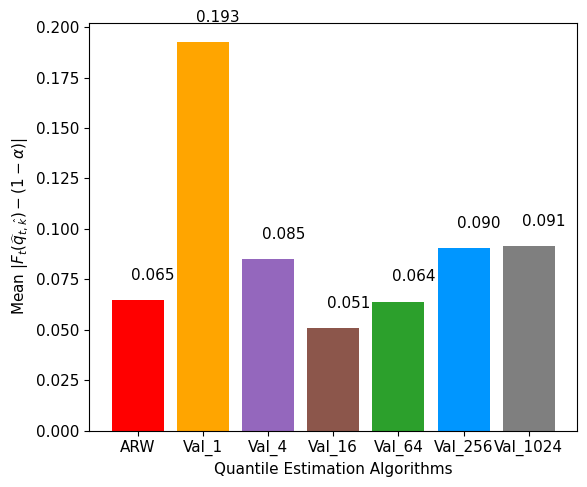

(7, 1, 1000)


In [4]:
#process results
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
num_methods = len(methods)

#save result dictionary to numpy array
CDF_array = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
rel_error = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
for (i, key) in enumerate(CDF_dict.keys()):
    for (j, variance) in enumerate(CDF_dict[key].keys()):
        for (trial, trial_CDF) in CDF_dict[key][variance].items():
            #record square errors 
            CDF_array[i, j, trial, :] = trial_CDF

#take average of cdf over time and trials for each variance (n_model * n_variance)
cdf_mean_over_variances = np.mean(np.mean(CDF_array[:, :, :, 100:], axis=3), axis=2)
print(cdf_mean_over_variances)
#take average of cdf over for each trial (n_model * n_variance * n_periods)
cdf_mean_over_trials = np.mean(CDF_array[:, :, :, :], axis=2)

#plot results in a more official template
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']

for (idx, variance) in enumerate(variances):
    print(f'Variance: {variance}')
    #for each variance, barplot mean MSE of each method
    fig, ax = plt.subplots(1, 1, figsize = (6,5))    
    ax.bar(range(num_methods), cdf_mean_over_variances[:, idx], color=colors, \
           width = 0.8)
    #show number on yaxis
    for i, v in enumerate(cdf_mean_over_variances[:, idx]):
        ax.text(i - 0.1, v + 0.01, f'{v:.3f}', color='black')
    ax.set_xlabel('Quantile Estimation Algorithms')
    ax.set_xticks(range(num_methods))
    ax.set_xticklabels(methods)
    #ax.set_xticklabels(['ARW', 'V1','Vfull'])
    ax.set_ylabel(r'Mean $|F_t(\widehat{q}_{t,\hat{k}}) - (1-\alpha)|$')
    mpl.rcParams.update({'font.size': 11})
    plt.tight_layout()
    plt.show()

    
    
    
    #uncomment to save the figure
    #plt.savefig(f'{DATAPATH}/{figname}_var{variance}.png', dpi=300, bbox_inches='tight')

print(cdf_mean_over_trials.shape)

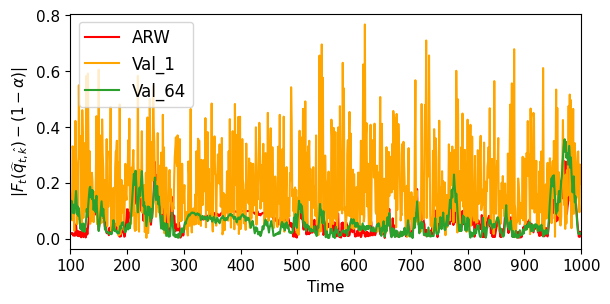

In [5]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 1, 4]

for v, variance in enumerate(variances):

    fig, ax = plt.subplots(1, 1, figsize = (6,3))

    for method in methods_to_plot:
        plt.plot(cdf_mean_over_trials[method][v], color=colors[method], label=methods[method])

    #ignore everything before 100
    plt.xlim(100, num_periods)
    #figure settings
    mpl.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.ylabel(r'$|F_t(\widehat{q}_{t,\hat{k}})-(1-\alpha)|$')
    plt.xlabel('Time')

    #uncomment to show legend and save the figure

    plt.legend()
    #plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')
